# Drive Test Tag Generation
Generate tags for the written portion of the chinese driving exam using a process similar to BERTopic.

## 1. Load Data
Loading data from a local database into a question bank class.

In [1]:
from src.qb.question_bank import QuestionBank
from data_storage.database.json_database import LocalJsonDB

db = LocalJsonDB("data_storage/database/json_db/data.json",
                 "data_storage/database/json_db/images")
qb : QuestionBank = db.load()
print(qb.question_count())

2836


## 2. Format Data
Although the Siglip2 model can handle images of different sizes, we will still standardize the image sizes to the same size to avoid unnecessary complications.

In [2]:
from data_cleaning.img_reshaper import ImgSquarer

IMG_DIR_256 = "data_cleaning/resized_imgs/img256"
IMG_DIR_512 = "data_cleaning/resized_imgs/img512"

squarer_256 = ImgSquarer(256)
# squarer_512 = ImgSquarer(512)

In [3]:
def resize_images(qb: QuestionBank, squarer: ImgSquarer, new_dir: str) -> None:
    for chapter_id in qb.get_all_chapter_num():
        for qid in qb.get_qids_by_chapter(chapter_id):
            question = qb.get_question(qid)
            if question.get_img_path() is not None:
                question.set_img_path(squarer.reshape(qid, qb.get_img_dir(), new_dir))

In [4]:
import os
# If the directory is empty, resize images.
if not os.listdir(IMG_DIR_256):
    print("Resizing images to 256x256...")
    resize_images(qb, squarer_256, IMG_DIR_256)
else:
    print("Images already resized to 256x256, skipping...")

Images already resized to 256x256, skipping...


## 3. Create Multimodal Embeddings
Create multimodal embeddings for the questions using a Siglip2 model.

In [5]:
# Library Imports
from transformers import AutoModel, AutoProcessor

# Local Imports
from embedder.siglip2_qb_embedder import Siglip2QBEmbedder

### a) Load/Download the Siglip2 Model
We will be using "google/siglip2-base-patch16-256" for this task.

In [6]:
import torch
MODEL_NAME = "google/siglip2-base-patch16-256"

model = AutoModel.from_pretrained(MODEL_NAME, torch_dtype=torch.float32, attn_implementation="sdpa")
processor = AutoProcessor.from_pretrained(MODEL_NAME, use_fast=True) # Ensure the model is on the correct device

### b) Create embeddings

#### i) Define a logger

In [7]:
import logging
from logging import Logger
from datetime import datetime
import os

LOGGING_PATH = "logs"

def get_logger(name: str) -> Logger:
    # Create logger
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO) # Set the logging level

    # Create a file handler with timestamp in filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    file_handler = logging.FileHandler(
        os.path.join(LOGGING_PATH, f"{name}_{timestamp}.log")
    )

    # Create formatter
    formatter = logging.Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )
    file_handler.setFormatter(formatter)

    # Add handler to logger
    logger.addHandler(file_handler)

    return logger

embedder_logger = get_logger("embedder")

#### ii) Create the embedder

In [8]:
custom_embedder = Siglip2QBEmbedder(model, processor, embedder_logger)

#### iii) Generate embeddings

In [9]:
EMBEDDINGS_DIR = "data_storage/embedding_dir"
EMBEDDING_FILE_NAME = "siglip2_embeddings.npz"

os.makedirs(EMBEDDINGS_DIR, exist_ok=True)
embedding_file = os.path.join(EMBEDDINGS_DIR, EMBEDDING_FILE_NAME)
print(embedding_file)

data_storage/embedding_dir/siglip2_embeddings.npz


In [10]:
if EMBEDDING_FILE_NAME in os.listdir(EMBEDDINGS_DIR):
    print(f"Embeddings already exist at {embedding_file}, skipping generation.")
else:
    print("Generating embeddings...")
    # Generate embeddings for the question bank
    embeddings = custom_embedder.encode_qb(qb)

Generating embeddings...


#### iv) Save embeddings

In [11]:
import numpy as np

def save_embeddings(embeddings, file_path):
    np.savez(file_path, **{str(qid): embeddings[qid] for qid in embeddings})

if not os.path.exists(embedding_file):
    print(f"Saving embeddings to {embedding_file}...")
    save_embeddings(embeddings, embedding_file)
else:
    print(f"Embeddings file {embedding_file} already exists, skipping save.")

Saving embeddings to data_storage/embedding_dir/siglip2_embeddings.npz...


## 4. Dimension Reduction

### a) Load Embeddings

In [12]:
# To load the embeddings later:
def load_embeddings(file_path):
    loaded = np.load(file_path)
    return {key: loaded[key] for key in loaded.files}
id_to_embedding = load_embeddings(embedding_file)

In [28]:
from typing import List

from embedder.siglip2_qb_embedder import format_question

def format_for_clustering(id_to_embedding: dict, qb: QuestionBank) -> (List[str], List[str], np.ndarray):
    """
    Format the embeddings for clustering.
    """
    qid_lst = []
    documents: List[str] = []
    embedding_lst: List[np.ndarray] = []
    for chapter_id in qb.get_all_chapter_num():
        for qid in qb.get_qids_by_chapter(chapter_id):
            doc = format_question(qb.get_question(qid), qb.describe_chapter(chapter_id))
            qid_lst.append(qid)
            documents.append(doc)
            embedding_lst.append(id_to_embedding[qid])
    embedding_array = np.array(embedding_lst)
    return qid_lst, documents, embedding_array

In [14]:
qid_lst, documents, embeds = format_for_clustering(id_to_embedding, qb)
print(f"Number of questions: {len(qid_lst)} "
      f"Embedding shape: {embeds.shape}")

Number of questions: 2836 Embedding shape: (2836, 768)


In [29]:
documents[:5]  # Display the first 5 documents to verify formatting

['章节:道路交通安全法律、法规和规章题目:申请人在场地和道路上学习驾驶，应当按规定取得学习驾驶证明，学习驾驶证明的有效期为五年。答案:错',
 '章节:道路交通安全法律、法规和规章题目:有听力障碍的机动车驾驶人驾驶机动车时，应当佩戴助听设备。答案:对',
 '章节:道路交通安全法律、法规和规章题目:醉酒驾驶非营运机动车的，由公安机关交通管理部门吊销机动车驾驶证，依法追究刑事责任，并且多少年内不得重新取得机动车驾驶证？答案:五年',
 '章节:道路交通安全法律、法规和规章题目:在道路上车辆发生故障、事故停车后，不按规定使用灯光或者设置警告标志的，一次记1分。答案:错',
 '章节:道路交通安全法律、法规和规章题目:A2实习期驾驶人驾驶机动车上高速公路行驶，以下做法正确的是什么？答案:应当由持有A2准驾车型驾驶证三年以上的驾驶人陪同']

### b) Set up dimension reduction model
We will be using UMAP for dimension reduction.

In [15]:
from umap import UMAP
def dim_reduction(dimensions: int, n_neighbors: int) -> np.ndarray:
    umap_model = UMAP(
        n_components=dimensions,
        metric='cosine',
        n_neighbors=n_neighbors,
        min_dist=0.0
    )
    rdc_embeds = umap_model.fit_transform(embeds)
    return rdc_embeds

### c) Experiment with different parameters
Using dimension 2, experiment with different values of `n_neighbors` to see how it affects the clustering.

In [16]:
def save_rdc_embeddings(embeddings, file_path):
    np.savez(file_path, embeddings=embeddings)

In [17]:
def load_rdc_embeddings(file_path):
    loaded = np.load(file_path)
    return loaded['embeddings']

In [18]:
from typing import Dict

def make_test_embeds() -> Dict[int, np.ndarray]:
    n_to_embed = {}
    for n in range(5, 30, 5):
        file_name = f"data_storage/embedding_dir/2d_rdc_embeds_n{n}.npz"
        if not os.path.exists(file_name):
            print(f"Reducing dimensions with n_neighbors={n}...")
            rdc_embeds = dim_reduction(2, n)
            n_to_embed[n] = rdc_embeds
            print(f"Saving reduced dimension embeddings to {file_name}...")
            save_rdc_embeddings(rdc_embeds, file_name)
        else:
            print(f"Reduced dimension embeddings file {file_name} already exists. Loading embedding.")
            n_to_embed[n] = load_rdc_embeddings(file_name)
    return n_to_embed

Visualize the embeddings using seaborn

In [19]:
n_to_embeds = make_test_embeds()

Reducing dimensions with n_neighbors=5...


/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Saving reduced dimension embeddings to data_storage/embedding_dir/2d_rdc_embeds_n5.npz...
Reducing dimensions with n_neighbors=10...


/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving reduced dimension embeddings to data_storage/embedding_dir/2d_rdc_embeds_n10.npz...
Reducing dimensions with n_neighbors=15...


/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving reduced dimension embeddings to data_storage/embedding_dir/2d_rdc_embeds_n15.npz...
Reducing dimensions with n_neighbors=20...


/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving reduced dimension embeddings to data_storage/embedding_dir/2d_rdc_embeds_n20.npz...
Reducing dimensions with n_neighbors=25...


/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving reduced dimension embeddings to data_storage/embedding_dir/2d_rdc_embeds_n25.npz...


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_2d_embeds(embeds_2d, title=None):
    """
    Plot a single 2D embedding using seaborn.

    Args:
        embeds_2d: 2D embeddings array with shape (n_samples, 2)
        title: Optional title for the plot

    Returns:
        The scatter plot object
    """
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(
        x=embeds_2d[:, 0],
        y=embeds_2d[:, 1],
        alpha=0.7,
        s=40  # Point size
    )
    if title:
        plt.title(title, fontsize=15)
    else:
        plt.title('2D Embedding Visualization', fontsize=15)
    plt.xlabel('UMAP Dimension 1', fontsize=12)
    plt.ylabel('UMAP Dimension 2', fontsize=12)
    plt.grid(alpha=0.3)

    # Remove top and right borders
    sns.despine()

    plt.tight_layout()
    return scatter

def plot_multiple_2d_embeds(n_to_embeds):
    """
    Plot multiple 2D embeddings with different n_neighbors values.

    Args:
        n_to_embeds: Dictionary mapping n_neighbors values to 2D embeddings

    Returns:
        The matplotlib figure containing all subplots
    """
    # Calculate grid dimensions based on number of embeddings
    n_plots = len(n_to_embeds)
    n_cols = min(3, n_plots)  # Maximum 3 columns
    n_rows = math.ceil(n_plots / n_cols)

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))

    # Flatten axes if it's a 2D array
    if n_plots > 1:
        if n_rows > 1 and n_cols > 1:
            axes = axes.flatten()
        elif n_rows == 1:
            axes = [axes[i] for i in range(n_cols)]
        elif n_cols == 1:
            axes = [axes[i] for i in range(n_rows)]
    else:
        axes = [axes]

    # Sort n values for consistent visualization
    sorted_n_values = sorted(n_to_embeds.keys())

    # Plot each embedding
    for i, n in enumerate(sorted_n_values):
        embeds = n_to_embeds[n]
        ax = axes[i]

        sns.scatterplot(
            x=embeds[:, 0],
            y=embeds[:, 1],
            alpha=0.7,
            s=30,
            ax=ax
        )

        ax.set_title(f'n_neighbors = {n}', fontsize=14)
        ax.set_xlabel('UMAP Dimension 1', fontsize=12)
        ax.set_ylabel('UMAP Dimension 2', fontsize=12)
        ax.grid(alpha=0.3)
        sns.despine(ax=ax)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    return fig

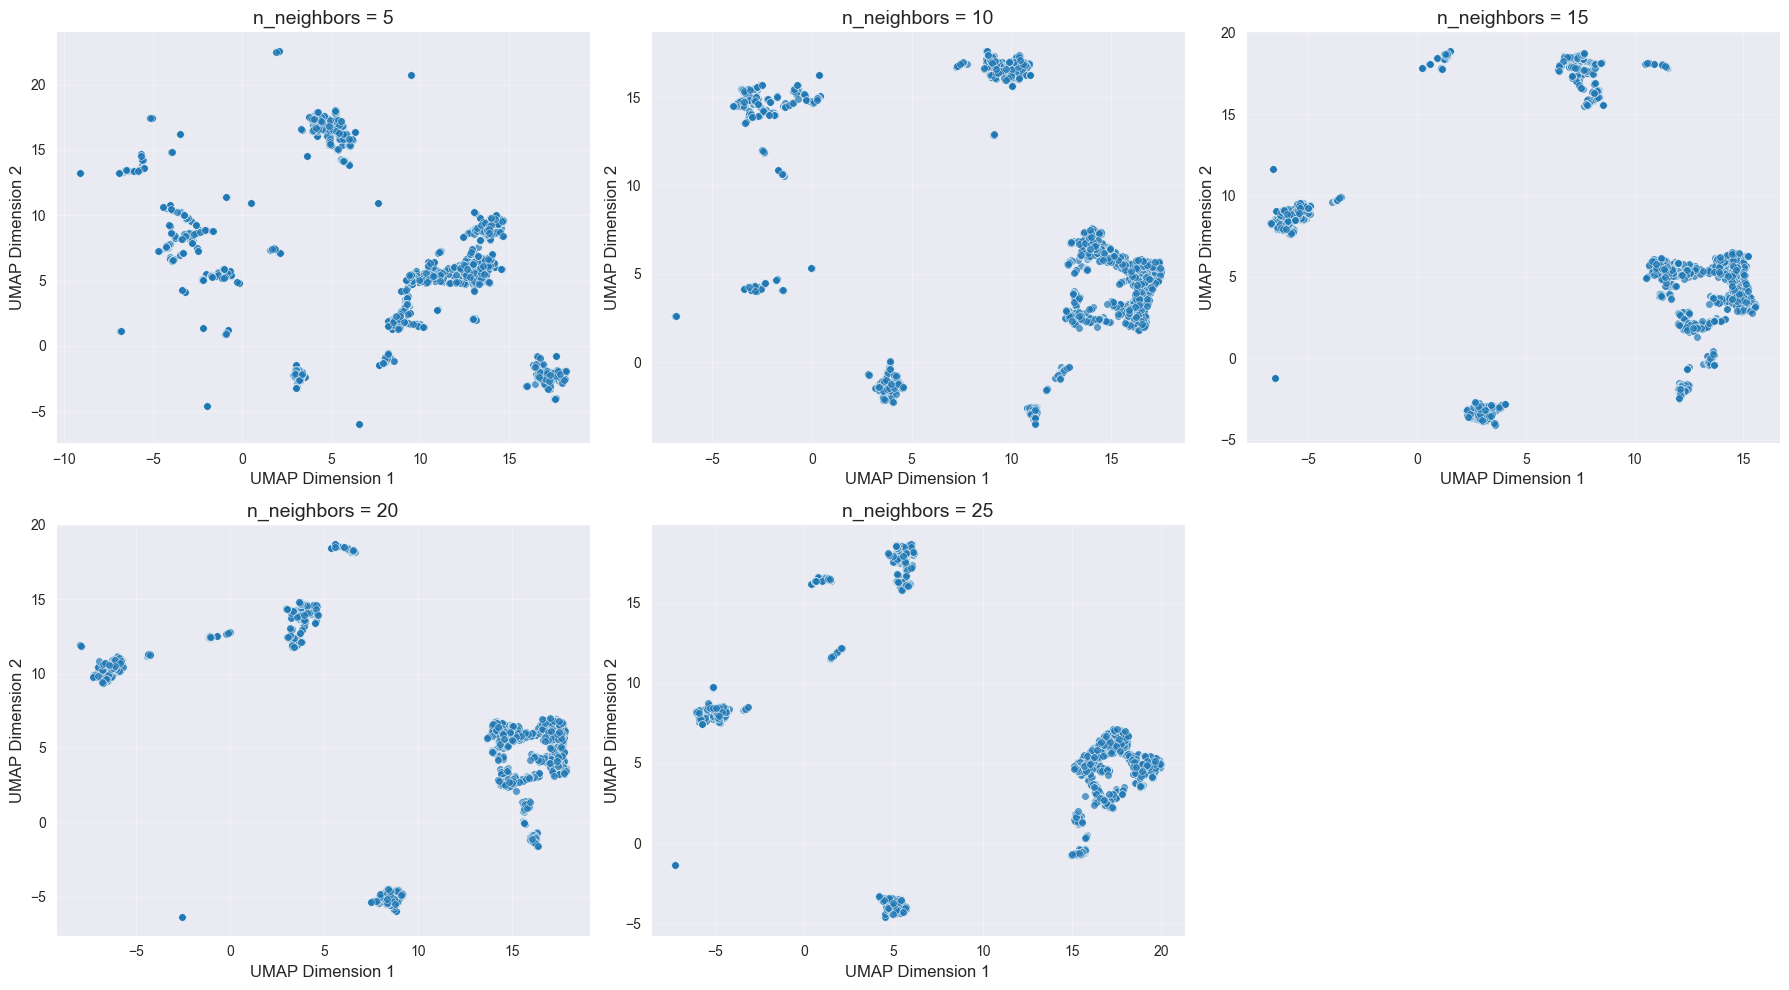

In [21]:
# Visualize the embeddings for different n_neighbors values
fig = plot_multiple_2d_embeds(n_to_embeds)
plt.show()

### d) Using an n_neighbors value, create high dimensional embeddings
We will be using n_neighbours = 10

In [22]:
n_neighbors = 10
dim = 256
rdc_embeds_path = f"data_storage/embedding_dir/rdc_embeds_n{n_neighbors}d{dim}.npz"
if not os.path.exists(rdc_embeds_path):
    print(f"Reducing dimensions to {dim} with n_neighbors={n_neighbors}...")
    rdc_embeds = dim_reduction(dim, n_neighbors)
    print(f"Saving reduced dimension embeddings to {rdc_embeds_path}...")
    save_rdc_embeddings(rdc_embeds, rdc_embeds_path)
else:
    print(f"Reduced dimension embeddings file {rdc_embeds_path} already exists. Loading embedding.")
    rdc_embeds = load_rdc_embeddings(rdc_embeds_path)
print(f"Embeddings successfully loaded. Shape: {rdc_embeds.shape}")

Reducing dimensions to 256 with n_neighbors=10...


/Users/simonxu/opt/anaconda3/envs/drivetest_tag_gen/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Saving reduced dimension embeddings to data_storage/embedding_dir/rdc_embeds_n10d256.npz...
Embeddings successfully loaded. Shape: (2836, 256)


## 5. Clustering


Generate a small representative sample of the question bank by clustering the questions and selecting representative questions from each cluster.

In [23]:
from sklearn.cluster import HDBSCAN
def cluster_embeddings(embeddings: np.ndarray) -> np.ndarray:
    """
    Cluster the embeddings using HDBSCAN.

    Args:
        embeddings: Embeddings array with shape (n_samples, n_features)

    Returns:
        Cluster labels for each embedding
    """
    clusterer = HDBSCAN(min_cluster_size=4, metric='cosine', min_samples=2, cluster_selection_method="leaf", cluster_selection_epsilon=0.00000001)
    cluster_labels = clusterer.fit_predict(embeddings)
    return cluster_labels

In [24]:
cluster_labels = cluster_embeddings(rdc_embeds)

In [25]:
from pandas import DataFrame

topic_df = DataFrame({"topic": cluster_labels, "id": qid_lst, "document": documents})
topic_df.head()

,topic,id,document
0,-1,ec1db,章节:道路交通安全法律、法规和规章题目:申请人在场地和道路上学习驾驶，应当按规定取得学习驾驶...
1,-1,cfaaf,章节:道路交通安全法律、法规和规章题目:有听力障碍的机动车驾驶人驾驶机动车时，应当佩戴助听设...
2,270,dd379,章节:道路交通安全法律、法规和规章题目:醉酒驾驶非营运机动车的，由公安机关交通管理部门吊销机...
3,25,f7903,章节:道路交通安全法律、法规和规章题目:在道路上车辆发生故障、事故停车后，不按规定使用灯光或...
4,274,f5780,章节:道路交通安全法律、法规和规章题目:A2实习期驾驶人驾驶机动车上高速公路行驶，以下做法正...


In [26]:
topic_df_sorted = topic_df.sort_values("topic", ascending=True)[topic_df["topic"] != -1]
topic_df_sorted.head(100)

/var/folders/71/jllnlvwn0gv1k0610m4_0dvh0000gn/T/ipykernel_5338/793402441.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  topic_df_sorted = topic_df.sort_values("topic", ascending=True)[topic_df["topic"] != -1]


,topic,id,document
1547,0,50791,章节:交通信号题目:这一组交通警察手势是什么信号？答案:停止信号
1124,0,76d87,章节:交通信号题目:这一组交通警察手势是什么信号？答案:直行信号
1746,0,f5269,章节:交通信号题目:请判断这是一个什么手势？答案:准许车辆左转弯手势
1577,0,ba64d,章节:交通信号题目:请判断这是一个什么手势？答案:准许车辆右转弯手势
1625,0,e7424,章节:交通信号题目:这一组交通警察手势是什么信号？答案:左转弯信号
...,...,...,...
736,8,8f8c9,章节:交通信号题目:这个导向箭头是何含义？答案:指示直行或右转弯
1765,8,86f18,章节:交通信号题目:路面上的黄色标记是何含义？答案:禁止掉头
789,8,3c180,章节:交通信号题目:这个导向箭头是何含义？答案:指示前方可直行或掉头
1102,8,eac5d,章节:交通信号题目:这个导向箭头是何含义？答案:提示前方有左弯或需向左合流
